## Batch experiments same as in Leonardo's paper

Visualize few "fakeness" maps of true/fake signatures

Use ELM implementation in `HPELM @ GPU` for speed

In [1]:
from hpelm import HPELM

In [2]:
import os
import pickle
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from PIL import Image
%matplotlib inline

In [3]:
data_folder = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB"
overlap = '50p'
samples = 10000000 // 30

data_file = "/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap{}.pkl".format(overlap)

# 

In [4]:
with open(data_file, 'rb') as f:
    X0 = pickle.load(f)
    
X0 = X0.reset_index(drop=True)

Make a `users` list of user batches, sizes `[50, 5, 5, 5, 5, 5]`

In [5]:
uu = list(X0.uid.unique())
random.shuffle(uu)
users = [uu[:50]]
users.extend([uu[i:i+5] for i in range(50,75,5)])

Make a data loader that gives us required batch, optionally setting aside 1 file per user

In [6]:
def load_batch(j, loo=False):
    """Load batch `j` of `users` list, as Numpy array.
    
    loo (bool, default=False): whether to return single LOO file per user separately.
    """    
    data = X0[X0.uid.isin(users[j])]
    
    if loo:
        # get LOO split
        t = data.loc[:, 'uid':'fid']
        t = t.sample(frac=1.0, replace=False)
        fid_loo = t.groupby('uid').first()['fid']

        data_loo = data[data.fid.isin(fid_loo)]
        data = data[~data.fid.isin(fid_loo)]
        Y_loo = data_loo.loc[:, 'sig_true'].to_numpy()
        U_loo = data_loo.loc[:, 'uid']
        Z_loo = data_loo.loc[:, '0':'1023'].to_numpy()

    Y = data.loc[:, 'sig_true'].to_numpy()
    Z = data.loc[:, '0':'1023'].to_numpy()
    
    zm = Z.mean()
    zs = Z.std().clip(min=0.5)
    Z = (Z - zm) / zs
    Z = Z.clip(min=-5, max=5)

    if loo:
        Z_loo = (Z_loo - zm) / zs
        Z_loo = Z_loo.clip(min=-5, max=5)
        return Z, Y, Z_loo, Y_loo, U_loo, data_loo
        
    return Z, Y

In [7]:
x,y,xv,yv,uv,dv = load_batch(2, loo=True)

#  

## pre-train

In [8]:
%%time
model = HPELM(1024, 1, norm=10**0.8, batch=10000)
#model.add_neurons(1, 'lin', W=np.zeros((1024,1)), B=np.ones(1,))
model.add_neurons(10000-1024, 'tanh')
model.add_neurons(1024, 'lin')

CPU times: user 323 ms, sys: 44.5 ms, total: 368 ms
Wall time: 369 ms


In [9]:
Xp, Yp = load_batch(0, loo=False)

In [10]:
%time model.add_data(Xp, Yp)

processing batch 1/55, eta 0:13:51
processing batch 2/55, eta 0:12:09
processing batch 3/55, eta 0:11:21
processing batch 4/55, eta 0:11:13
processing batch 5/55, eta 0:11:11
processing batch 6/55, eta 0:11:07
processing batch 7/55, eta 0:10:47
processing batch 8/55, eta 0:10:23
processing batch 9/55, eta 0:10:01
processing batch 10/55, eta 0:09:45
processing batch 11/55, eta 0:09:31
processing batch 12/55, eta 0:09:19
processing batch 13/55, eta 0:09:10
processing batch 14/55, eta 0:08:52
processing batch 15/55, eta 0:08:34
processing batch 16/55, eta 0:08:20
processing batch 17/55, eta 0:08:05
processing batch 18/55, eta 0:07:49
processing batch 19/55, eta 0:07:34
processing batch 20/55, eta 0:07:20
processing batch 21/55, eta 0:07:06
processing batch 22/55, eta 0:06:52
processing batch 23/55, eta 0:06:38
processing batch 24/55, eta 0:06:25
processing batch 25/55, eta 0:06:12
processing batch 26/55, eta 0:06:00
processing batch 27/55, eta 0:05:47
processing batch 28/55, eta 0:05:34
p

##  

#### fine-tune

In [11]:
x, y, xv, yv, uv, dv = load_batch(1, loo=True)

model.add_data(x, y)
model.nnet.solve()

yh1 = model.predict(xv)
yv1 = yv[:,None]
res_k = pd.DataFrame(np.hstack((yv1, yh1)), index=uv).groupby('uid').mean()

processing batch 1/6, eta 0:01:08
processing batch 2/6, eta 0:00:53
processing batch 3/6, eta 0:00:38
processing batch 4/6, eta 0:00:25
processing batch 5/6, eta 0:00:12


##  

### Prepare results 

In [12]:
def make_Gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [13]:
P0 = pd.concat((dv.loc[:, :'ymax'], dv.loc[:, 'fname':], pd.Series(yh1[:,0], index=dv.index, name='proba')), axis=1)

In [14]:
P0.uid.unique()

array([ 50, 116, 117,  49,  47])

In [19]:
for uid in P0.uid.unique():
    print(P0[P0.uid == uid].iloc[0].sig_true)

1
0
1
0
1


#  

In [38]:
P = P0[P0.uid == 49]
P.head(2)

,wsize,overlap,xmin,ymin,xmax,ymax,fname,uid,fid,sig_true,proba
735438,64,50,0,0,64,64,/Users/akusok/wrkdir/research-signatures-data/...,49,2027,0,0.451859
735439,64,50,32,0,96,64,/Users/akusok/wrkdir/research-signatures-data/...,49,2027,0,0.515413


In [39]:
img = np.zeros((850, 360))

In [40]:
for i, row in P.iterrows():
    x0 = int(row.xmin)
    x1 = int(row.xmax)
    y0 = int(row.ymin)
    y1 = int(row.ymax)
    s = row.wsize  # fix kernels cut on one side

    if row.proba > 0.6:
        # kern = make_Gaussian(s, fwhm=s) * row.proba
        # img[x0:x1, y0:y1] = np.maximum(kern[:x1-x0, :y1-y0], img[x0:x1, y0:y1])
        img[x0:x1, y0:y1] = np.maximum(img[x0:x1, y0:y1], row.proba)

In [41]:
imgfile = P.fname.iloc[0].split('p/')[1].split('_fea')[0]
imgfname = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB/{:04d}/{}.png".format( P.uid.iloc[0], imgfile)
sig = Image.open(imgfname)

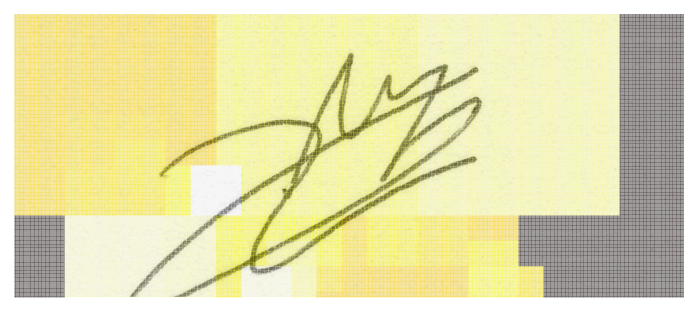

In [42]:
sn.heatmap(img.T, square=True, cmap='hot', alpha=0.1, cbar=False, xticklabels=[], yticklabels=[])
plt.imshow(sig)
plt.show()

In [43]:
i3 = img.copy()
s3 = sig.copy()

In [31]:
i2 = img.copy()
s2 = sig.copy()

In [25]:
i1 = img.copy()
s1 = sig.copy()

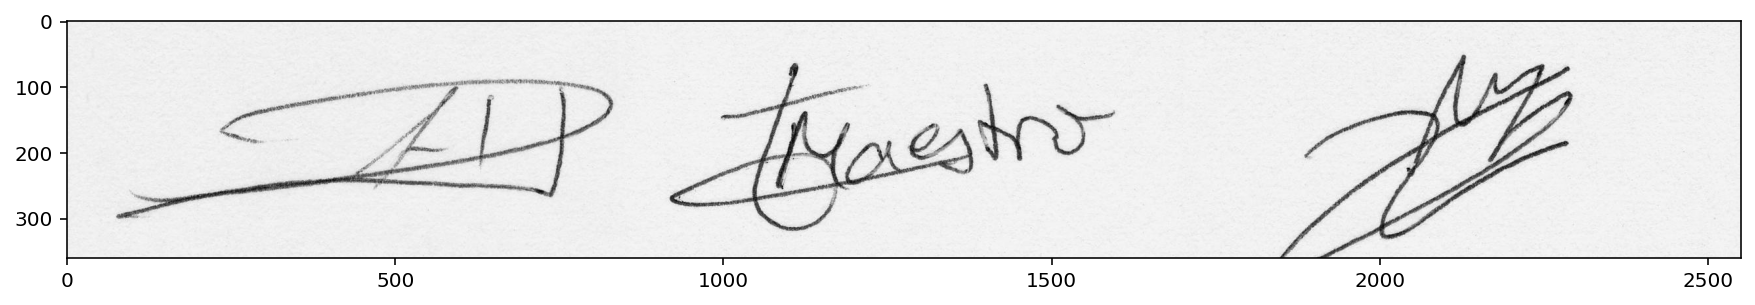

In [45]:
plt.figure(figsize=(15,4))
sall = np.hstack((s2, s1, s3))
plt.imshow(sall)#, alpha=np.ones(sall.shape))

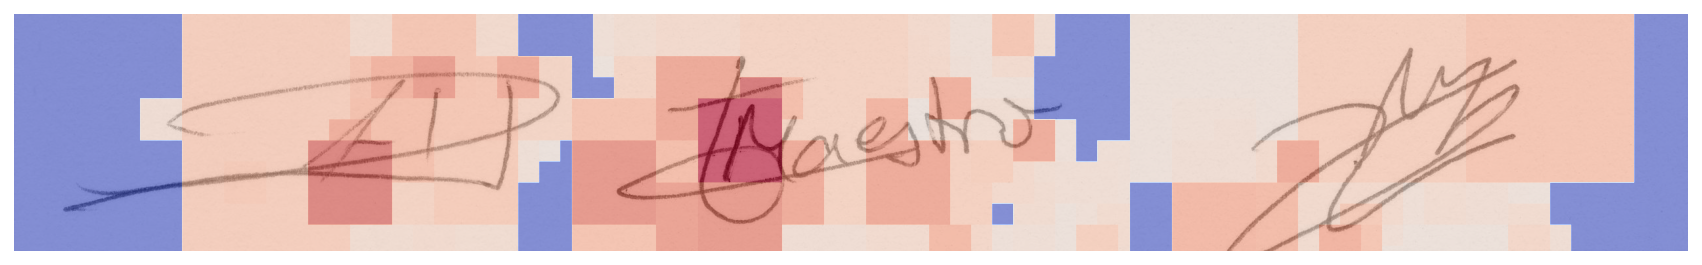

In [59]:
plt.figure(figsize=(15,4))
sall = np.hstack((s2, s1, s3))
plt.imshow(sall)#, alpha=np.array(sall < 100, dtype=np.float))
plt.imshow(np.vstack((i2, i1, i3)).T, cmap='coolwarm', alpha=0.6)

plt.axis('off')
plt.savefig("sig_color.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

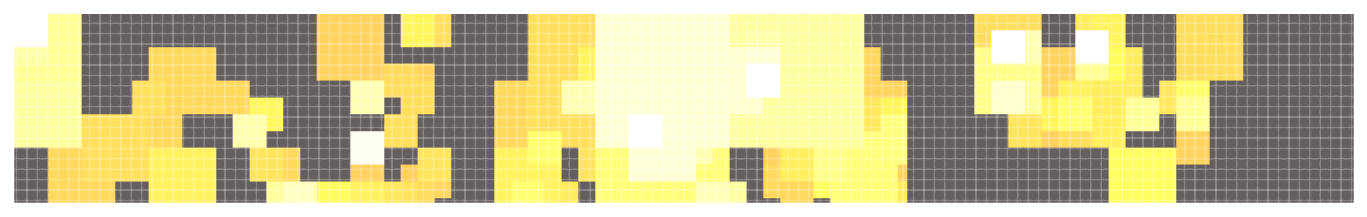

In [89]:
plt.figure(figsize=(12,3))
#sn.heatmap(np.vstack((i2, i1, i3)).T, robust=True, square=True, cmap='hot', alpha=0.1, cbar=False, xticklabels=[], yticklabels=[])
#plt.imshow(np.hstack((s2, s1, s3)))
plt.show()

# 

#### read results

In [136]:
R = pd.concat(res, axis=0)
R

,0,1
uid,,
37,0.0,0.497648
46,1.0,0.600573
67,0.0,0.520491
72,0.0,0.569078
74,1.0,0.538123
17,1.0,0.630476
18,0.0,0.572745
36,0.0,0.362570
99,0.0,0.394479


In [137]:
pt = R[0]
ph = R[1]

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
accuracy_score(pt>0.5, ph>0.5)

0.76

In [107]:
pass

0.76

In [92]:
pass

0.76

In [65]:
pass

0.72

### ROC curve

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score

In [141]:
fpr, tpr, thresholds = roc_curve(pt, ph)

In [142]:
auc = roc_auc_score(pt, ph)

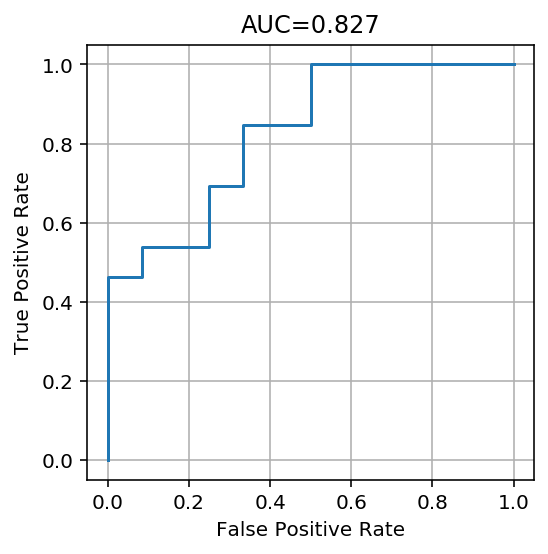

In [143]:
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.grid('minor')
plt.title("AUC={:.3f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("binary-roc.pdf", bbox_inches='tight')
plt.show()

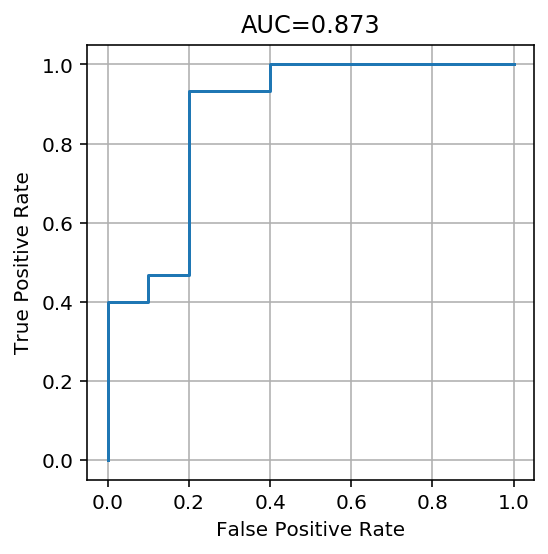

In [111]:
pass

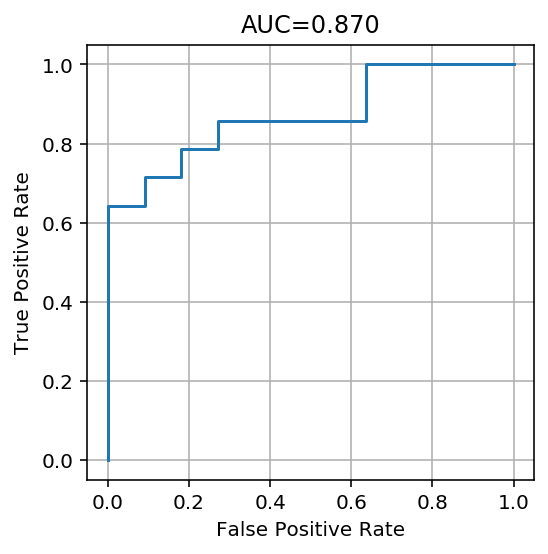

In [98]:
pass

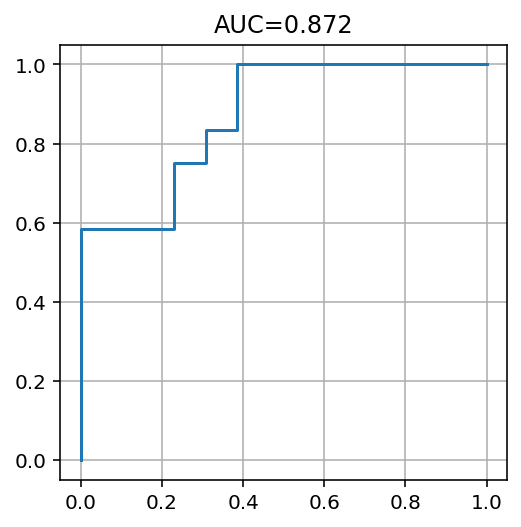

In [80]:
pass

In [ ]:
R.mean(axis=0)

In [ ]:
pass